<a href="https://colab.research.google.com/github/siddhusalvi/Covid-Data-Visualization/blob/AgeAnalysis/Covid_Data_Visualisation_using_Python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### File System and Spark Setup


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

In [ ]:
!apt-get update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://archive.apache.org/dist/spark/spark-2.3.1/spark-2.3.1-bin-hadoop2.7.tgz
!tar xf spark-2.3.1-bin-hadoop2.7.tgz
!pip install -q findspark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.3.1-bin-hadoop2.7"
import findspark
findspark.init()
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate() 
spark

### Plotly Setup

In [ ]:
!pip install plotly==4.7.1
!wget https://github.com/plotly/orca/releases/download/v1.2.1/orca-1.2.1-x86_64.AppImage -O /usr/local/bin/orca
!chmod +x /usr/local/bin/orca
!apt-get install xvfb libgtk2.0-0 libgconf-2-4
import plotly.graph_objects as go

### DataFrame and SQL Operations



In [4]:
path = '/content/drive/My Drive/Siddhu/data/covidData.json'

In [5]:
from pyspark.sql.types import ArrayType, StructField, StructType, StringType, IntegerType,DateType
from pyspark.sql.functions import col,when

In [6]:
schema = StructType([
          StructField("agebracket", StringType(), True),
          StructField("backupnotes", StringType(), True),
          StructField("contractedfromwhichpatientsuspected", StringType(), True),
          StructField("currentstatus", StringType(), True),
          StructField("dateannounced", DateType(), True),
          StructField("detectedcity", StringType(), True),
          StructField("detecteddistrict", StringType(), True),
          StructField("detectedstate", StringType(), True),
          StructField("estimatedonsetdate", StringType(), True),
          StructField("gender", StringType(), True),
          StructField("nationality", StringType(), True),
          StructField("notes", StringType(), True),
          StructField("numcases", StringType(), True),
          StructField("patientnumber", StringType(), True),
          StructField("source1", StringType(), True),
          StructField("source2", StringType(), True),
          StructField("source3", StringType(), True),
          StructField("statecode", StringType(), True),
          StructField("statepatientnumber", StringType(), True),
          StructField("statuschangedate", DateType(), True),
          StructField("typeoftransmission", StringType(), True)
])

In [7]:
covidDF = spark.read.option("dateFormat", "dd/MM/yyyy").json(path, schema)

In [8]:
covidDF.count()

28183

In [ ]:
covidDF.show()

In [10]:
covidDF.printSchema

<bound method DataFrame.printSchema of DataFrame[agebracket: string, backupnotes: string, contractedfromwhichpatientsuspected: string, currentstatus: string, dateannounced: date, detectedcity: string, detecteddistrict: string, detectedstate: string, estimatedonsetdate: string, gender: string, nationality: string, notes: string, numcases: string, patientnumber: string, source1: string, source2: string, source3: string, statecode: string, statepatientnumber: string, statuschangedate: date, typeoftransmission: string]>

#### Infected Gender


In [11]:
def getGenderData(dataframe,columnName):
  return dataframe.groupby(columnName).count() 

In [12]:
columnName = 'gender'
getGenderData(covidDF,columnName).show()

+------+-----+
|gender|count|
+------+-----+
|     F| 1766|
|     M| 3547|
|      |22870|
+------+-----+



#### Infected Patient by cities



In [13]:
def getPatientsByCity(dataframe,columnName):
  return dataframe.groupby(columnName).count().orderBy(col("count").desc()).where(col(columnName) != "")

In [14]:
columnName = 'detectedcity'
getPatientsByCity(covidDF,columnName).show(5)

+------------+-----+
|detectedcity|count|
+------------+-----+
|       Thane|  108|
|        MCGM|  108|
| Navi Mumbai|   71|
|         PMC|   69|
| Vasai-Virar|   61|
+------------+-----+
only showing top 5 rows



#### Recovered Patient by cities



In [15]:
def getRecoveredPatientsByCity(dataframe,columnName,city,status):
  return dataframe.filter(col(columnName)==columnStatus).groupby(city).count().orderBy(col("count").desc()).where(col(city) != "")

In [16]:
columnName = 'currentstatus'
columnStatus = 'Recovered'
city = 'detectedcity'

In [17]:
getRecoveredPatientsByCity(covidDF,columnName,city,columnStatus).show(5)

+------------+-----+
|detectedcity|count|
+------------+-----+
|   Bengaluru|   23|
|    Gurugram|   12|
|       Ranni|    7|
|       Kochi|    6|
|Gauribidanur|    5|
+------------+-----+
only showing top 5 rows



####Spliting Patients into AgeGroups




In [18]:
def getAgeGroupCount(dataframe,ageColumn):
  return dataframe.withColumn("age",col(ageColumn).cast("Integer"))\
  .withColumn("agegroup",when(col("age") < 15 ,"Minor").when((col('age') > 14) & (col("age")< 31),"Young").when((col('age') > 30) & (col("age")< 51),"Adult").when(col("age")> 50,"Older"))\
  .filter(col('agegroup') != "null" )\
  .groupby('agegroup').count()

In [19]:
columnName = 'agebracket'
getAgeGroupCount(covidDF,columnName).show()

+--------+-----+
|agegroup|count|
+--------+-----+
|   Older|  584|
|   Minor|  161|
|   Adult|  920|
|   Young|  677|
+--------+-----+



In [20]:
from pyspark.sql.types import ArrayType, StructField, StructType, StringType, IntegerType,DateType,DoubleType
from pyspark.sql.functions import col,when,isnull

In [21]:
casesSchema = StructType() \
      .add("Date",DateType(),True) \
      .add("DailyConfirmed",IntegerType(),True) \
      .add("TotalCases",IntegerType(),True) \
      .add("DailyRecovered",IntegerType(),True) \
      .add("TotalRecovered",IntegerType(),True) \
      .add("DailyDeceased",IntegerType(),True) \
      .add("TotalDeceased",IntegerType(),True)

In [ ]:
path = '/content/drive/My Drive/Siddhu/data/nation_data.csv'
nationDataDF = spark.read\
.format('csv')\
.schema(casesSchema)\
.option("dateFormat", "dd/MM/YYYY")\
.option("header",True)\
.load(path)
nationDataDF.show()

In [23]:
date = nationDataDF.toPandas()['Date']
dailyConfirmed = nationDataDF.toPandas()['DailyConfirmed']
totalCases = nationDataDF.toPandas()['TotalCases']
dailyRecovered = nationDataDF.toPandas()['DailyRecovered']
totalRecovered = nationDataDF.toPandas()['TotalRecovered']
dailyDeceased = nationDataDF.toPandas()['DailyDeceased']
totalDeceased = nationDataDF.toPandas()['TotalDeceased']

#Cases Visualization


In [24]:
import plotly.graph_objects as go
import plotly.express as px

####Total Cases


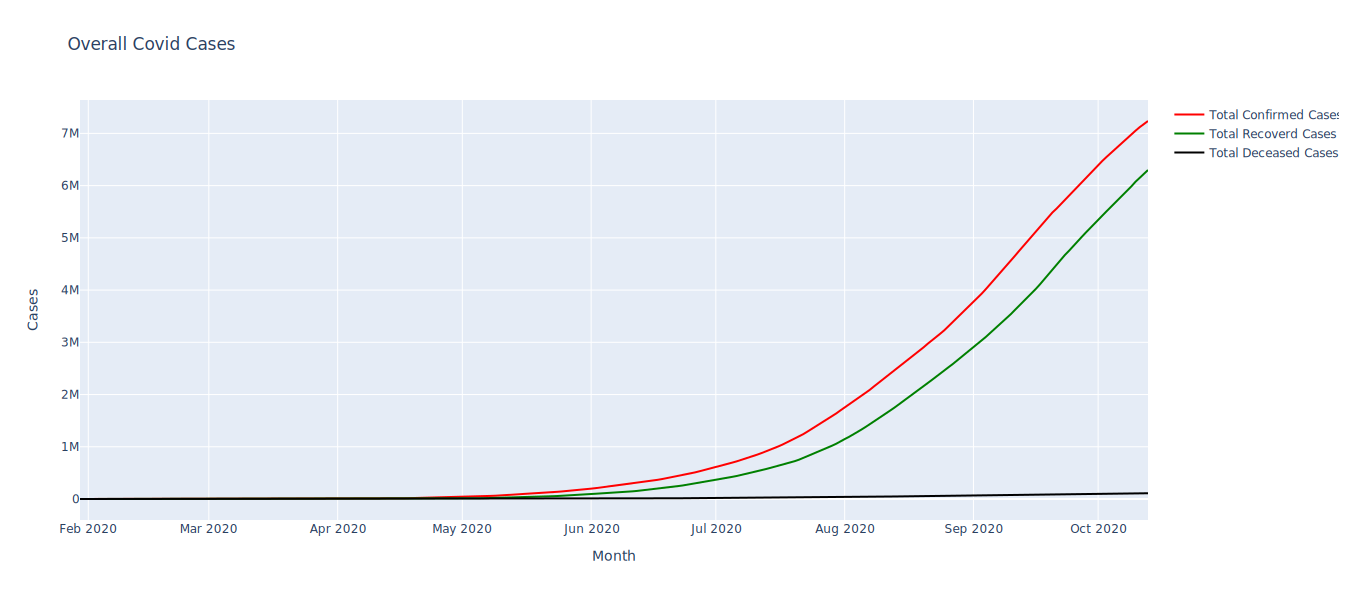

In [25]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=date, y=totalCases, name='Total Confirmed Cases',line=dict(color='red')))
fig.add_trace(go.Scatter(x=date, y=totalRecovered, name='Total Recoverd Cases',line=dict(color='green')))
fig.add_trace(go.Scatter(x=date, y=totalDeceased, name='Total Deceased  Cases',line=dict(color='black')))
fig.update_layout(title='Overall Covid Cases',xaxis_title='Month', yaxis_title='Cases')
fig.show('svg',width=1350,height=600)

####Daily Cases

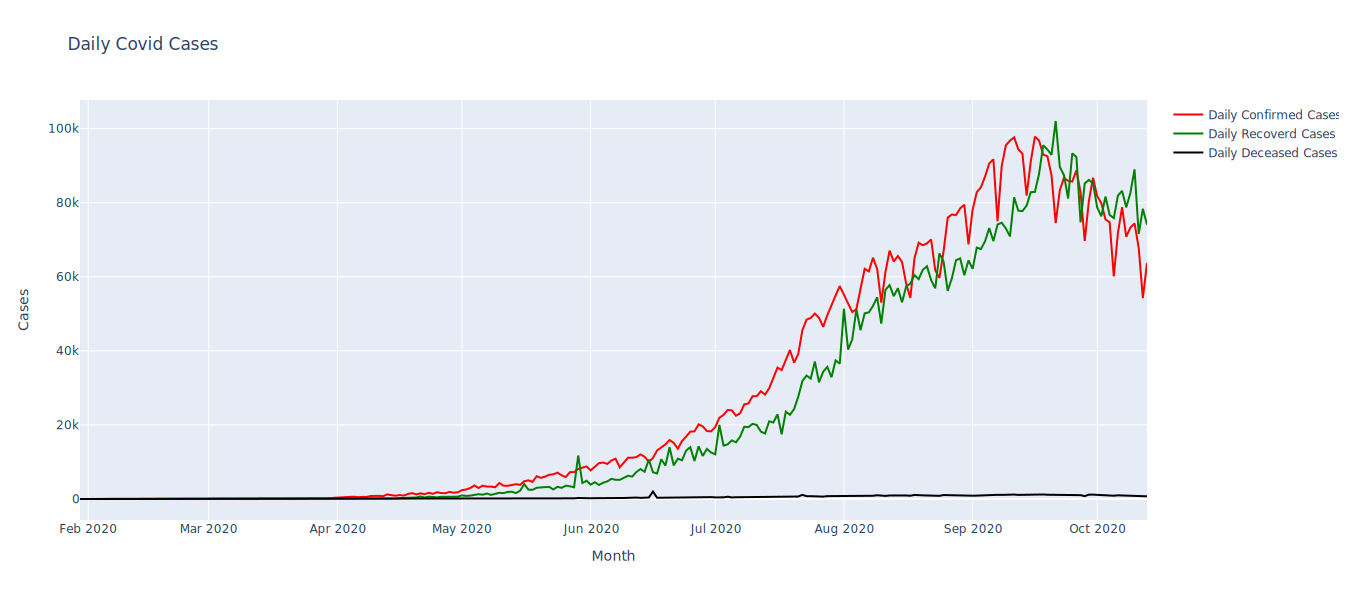

In [26]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=date, y=dailyConfirmed, name='Daily Confirmed Cases',line=dict(color='red')))
fig.add_trace(go.Scatter(x=date, y=dailyRecovered, name='Daily Recoverd Cases',line=dict(color='green')))
fig.add_trace(go.Scatter(x=date, y=dailyDeceased, name='Daily Deceased  Cases',line=dict(color='black')))
fig.update_layout(title='Daily Covid Cases',xaxis_title='Month', yaxis_title='Cases')
fig.show('svg',width=1350,height=600)

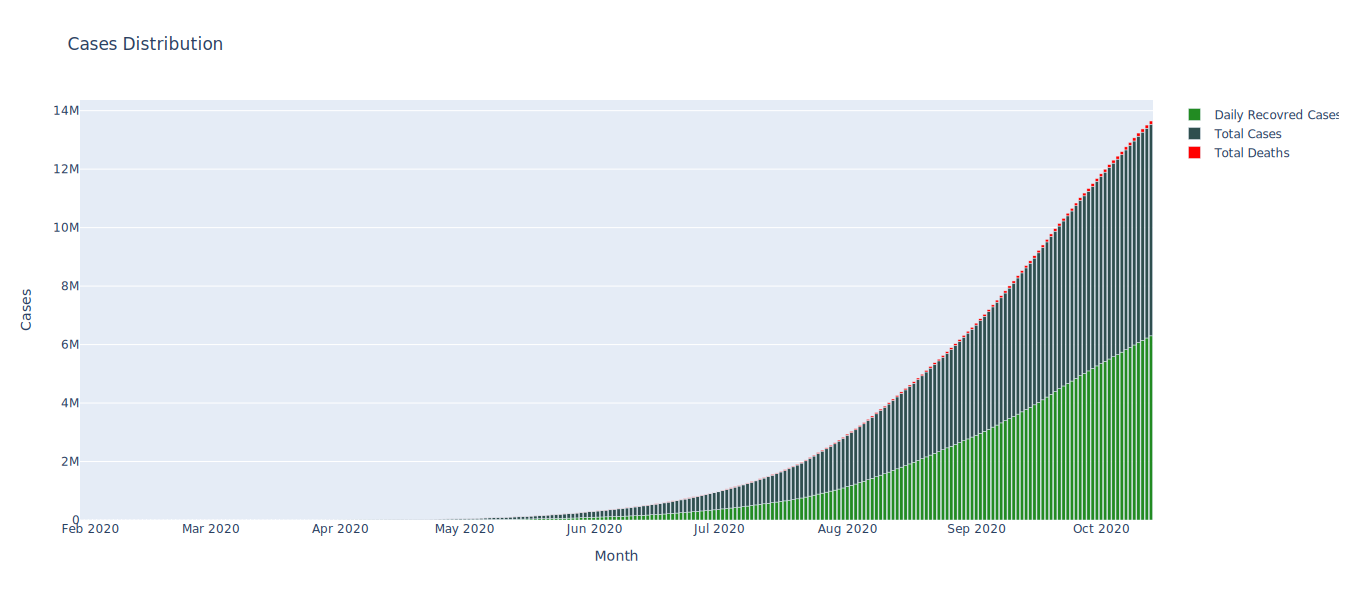

In [27]:
fig = go.Figure()
fig.add_trace(go.Bar(x=date,y=totalRecovered,name='Daily Recovred Cases',marker_color = 'ForestGreen'))
fig.add_trace(go.Bar(x=date,y=totalCases,name='Total Cases',marker_color = 'DarkSlateGrey'))
fig.add_trace(go.Bar(x=date,y=totalDeceased,name='Total Deaths',marker_color = 'red'))
fig.update_layout(title='Cases Distribution',barmode = 'relative',xaxis_title='Month', yaxis_title='Cases')
fig.show('svg',width=1350,height=600)

####Active Cases and Deaths


In [28]:
activeCaseses = totalCases - totalRecovered - totalDeceased

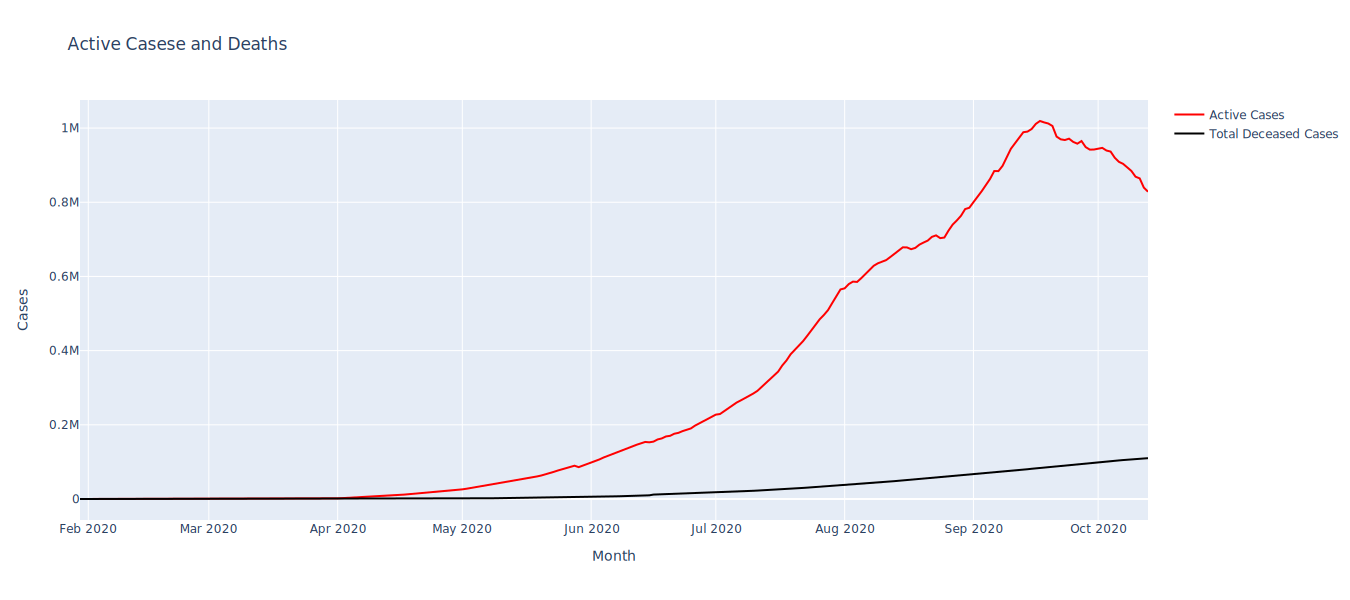

In [29]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=date, y=activeCaseses, name='Active Cases',line=dict(color='red')))
fig.add_trace(go.Scatter(x=date, y=totalDeceased, name='Total Deceased  Cases',line=dict(color='black')))
fig.update_layout(title='Active Casese and Deaths',xaxis_title='Month', yaxis_title='Cases')
fig.show('svg',width=1350,height=600)

In [30]:
patientData = ['ActiveCases','RecoveredCases','DeceasedCases']
totalPatients = nationDataDF.agg({"TotalCases": "max"}).collect()[0][0]
recoveredPatients = nationDataDF.agg({"TotalRecovered": "max"}).collect()[0][0]
deceasedPatients = nationDataDF.agg({"TotalDeceased": "max"}).collect()[0][0]
activePatients = totalPatients - recoveredPatients - deceasedPatients
patientValues =[activePatients,recoveredPatients,deceasedPatients]

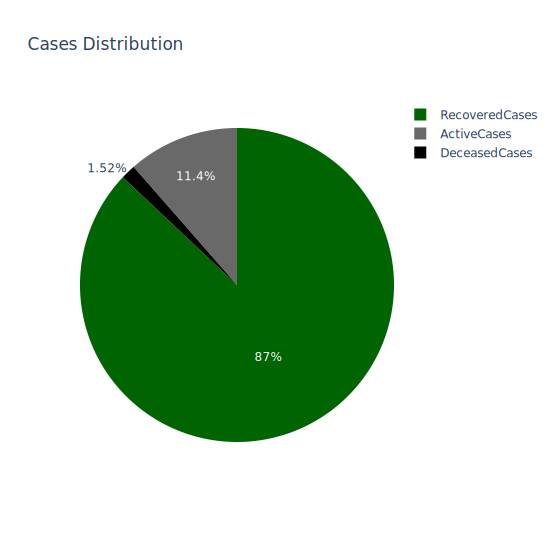

In [31]:
fig = px.pie(names=patientData, values=patientValues, title="Cases Distribution",color=patientData,color_discrete_map={'ActiveCases':'DimGrey','RecoveredCases':'DarkGreen','DeceasedCases':'#000000'})
fig.show('svg',width=550,height=550)

####Recovery Rate



In [32]:
recoveryRateDf = nationDataDF.withColumn('RecoveryRate',10*(col('TotalRecovered')/(col('TotalCases')-col('TotalRecovered')-col('TotalDeceased'))))\
.withColumn('ActiveCases',col('TotalCases')-col('TotalRecovered')-col('TotalDeceased'))\
.filter(col('RecoveryRate')>0)
recoveryDate = recoveryRateDf.toPandas()['Date']
recoveryRate = recoveryRateDf.toPandas()['RecoveryRate']

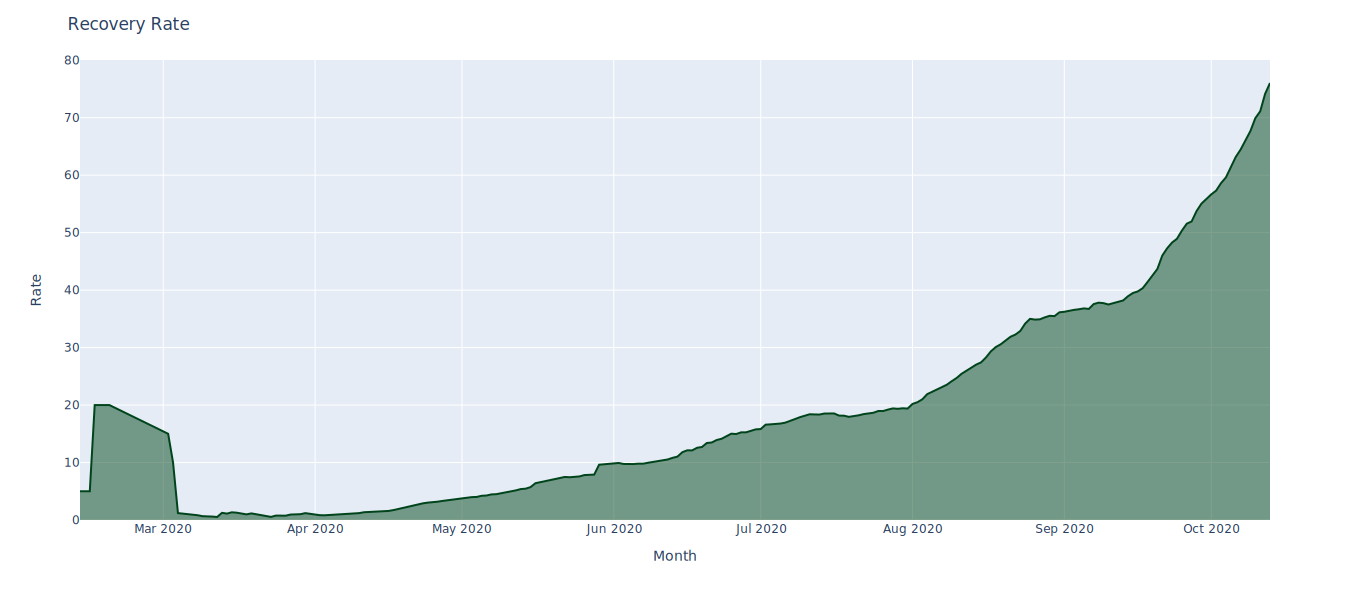

In [33]:
fig = px.area(x=recoveryDate,y=recoveryRate,color_discrete_sequence=px.colors.sequential.Greens_r)
fig.update_layout(title='Recovery Rate',xaxis_title='Month', yaxis_title='Rate')
fig.show('svg',width=1350,height=600)

#States Analysis


#### SQL opeartion

In [34]:
from pyspark.sql.types import ArrayType, StructField, StructType, StringType,DoubleType, IntegerType,DateType
from pyspark.sql.functions import col,when,isnull

In [35]:
import json

In [36]:
statesSchema = StructType() \
      .add("Date",DateType(),True) \
      .add("State",StringType(),True) \
      .add("Latitude",DoubleType(),True) \
      .add("Longitude",DoubleType(),True) \
      .add("TotalCases",DoubleType(),True) \
      .add("Death",IntegerType(),True) \
      .add("Cured",DoubleType(),True) \
      .add("NewCases",IntegerType(),True) \
      .add("NewDeaths",IntegerType(),True) \
      .add("NewCured",IntegerType(),True) 

In [ ]:
path = "/content/drive/My Drive/Siddhu/data/covid_states.csv"
statesDatadF = spark.read\
.format('csv')\
.schema(statesSchema)\
.option("dateFormat", "YYYY/MM/dd")\
.option("header",True)\
.load(path)
statesDataDF = statesDatadF.toPandas()
print(statesDataDF)

In [38]:
path = "/content/drive/My Drive/Siddhu/data/india.geojson"

In [39]:
statesData = json.load(open(path))

In [40]:
state_id_map = {}
for feature in statesData['features']:
  feature['id'] = feature['properties']['state_code']
  state_id_map[feature['properties']['st_nm']]=feature['id']  

In [41]:
statesDataDF['id'] = statesDataDF['State'].apply(lambda x :state_id_map[x])

In [ ]:
print(statesDataDF)

##Statewise Patients


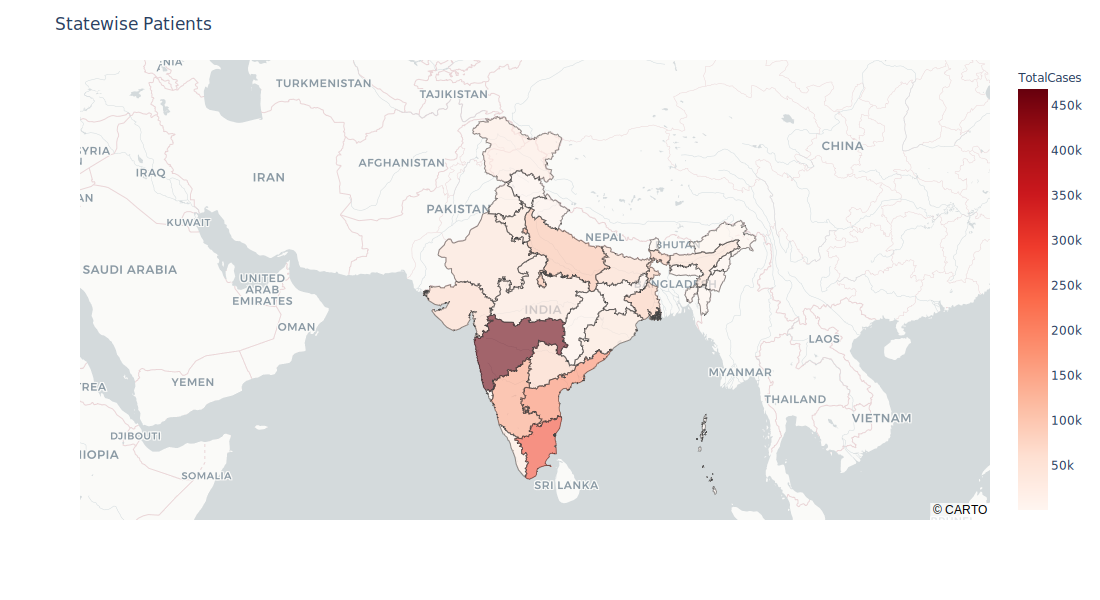

In [43]:
fig = px.choropleth_mapbox(
              statesDataDF,
              locations='id',
              geojson=statesData,
              color='TotalCases',
              color_continuous_scale="Reds",
              mapbox_style='carto-positron',
              hover_name='State',
              center={'lat':24,'lon':78},
              zoom = 3,
              opacity=0.6)

fig.update_layout(title='Statewise Patients')
fig.show('svg',width=1100,height=600)

In [44]:
schema = StructType()\
  .add("Date",DateType(),True)\
  .add("State",StringType(),True)\
  .add("Tests",IntegerType(),True)\

In [45]:
path = "/content/drive/My Drive/Siddhu/data/covid_cases.csv"
testsDatadF = spark.read\
.format('csv')\
.schema(schema)\
.option("dateFormat", "MM/dd/YYYY")\
.option("header",True)\
.load(path)

testsDataDF = testsDatadF.toPandas().drop(columns=['Date'])
testDF = statesDataDF.merge(testsDataDF, on='State', how='inner')

####Tests Conducted by Tests


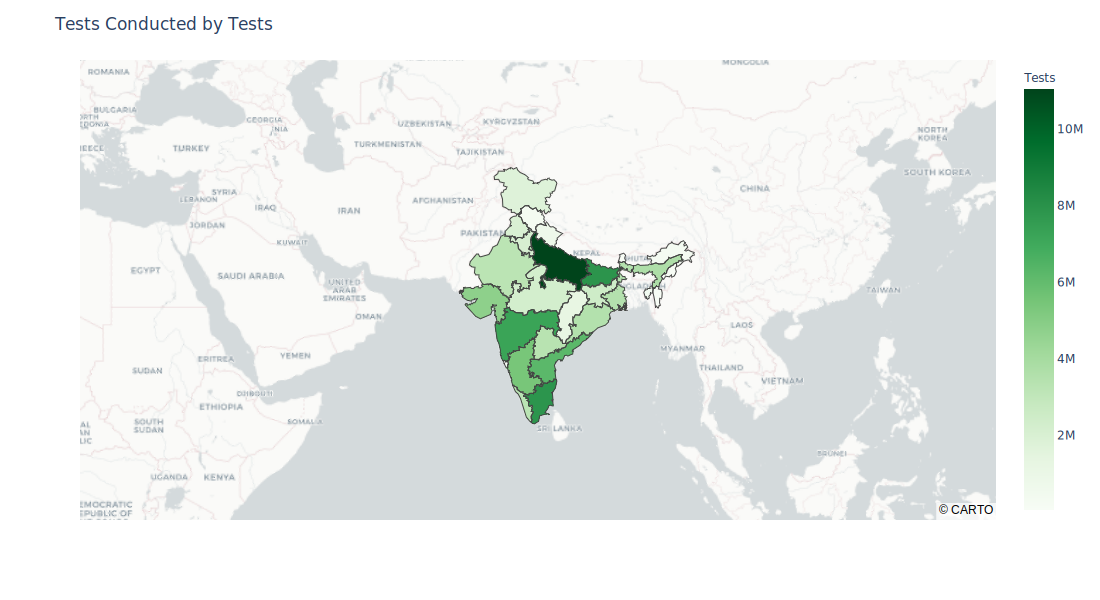

In [46]:
fig = px.choropleth_mapbox(
              testDF,
              locations='id',
              geojson=statesData,
              color='Tests',
              color_continuous_scale="Greens",
              mapbox_style='carto-positron',
              hover_name='State',
              center={'lat':24,'lon':78},
              zoom = 2.5,
              opacity=1
              )
fig.update_layout(title='Tests Conducted by Tests')
fig.show('svg',width=1100,height=600)

#Age Analysis


In [51]:
columnName = 'agebracket'
ageGroupSparkDF = getAgeGroupCount(covidDF,columnName)
ageGroupDF = ageGroupSparkDF.toPandas()

####Infected Age Group


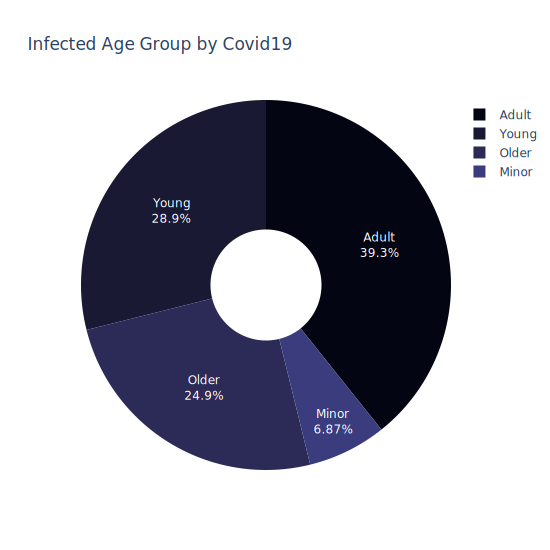

In [78]:
fig = px.pie(ageGroupDF, values='count', names='agegroup',title='Infected Age Group by Covid19' ,color_discrete_sequence=px.colors.sequential.ice,hole=0.3)
fig.update_traces(textinfo='label+percent',textposition='inside')
fig.update_layout(uniformtext_minsize=12, uniformtext_mode='hide')
fig.show('svg',width=550,height=550)

#### Deceased Age Group

In [66]:
def getDeceasedAgeGroupData(dataframe,columnName,deathColumn,deathWord):
  return dataframe.withColumn("age",col(columnName).cast("Integer"))\
  .withColumn("agegroup",when(col("age") < 15,"Minor").when(col("age")< 30,"Young")\
  .when(col("age")< 51,"Adult").when(col("age")> 50,"Older"))\
  .filter(col('agegroup') != "null" )\
  .filter(col(deathColumn)==deathWord)\
  .groupby('agegroup').count()

In [69]:
columnName = "agebracket"
deathColumn = 'currentstatus'
deathWord = 'Deceased'
DeceasedAgeGroupDF = getDeceasedAgeGroupData(covidDF,columnName,deathColumn,deathWord).toPandas()

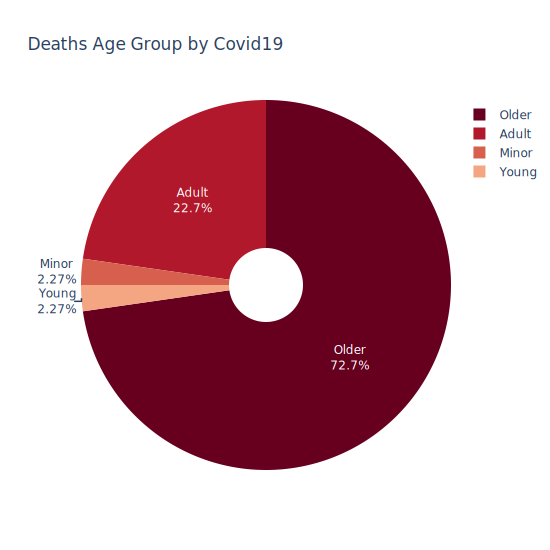

In [81]:
fig = px.pie(DeceasedAgeGroupDF, values='count', names='agegroup',title='Deaths Age Group by Covid19' ,color_discrete_sequence=px.colors.sequential.RdBu,hole=0.2)
fig.update_traces(textinfo='label+percent')
fig.update_layout(uniformtext_minsize=12, uniformtext_mode='hide')
fig.show('svg',width=550,height=550)